In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from finance_byu.regtables import Regtable
import tqdm

# Helper Functions

In [13]:
def LoadAndFormatData(date_to_begin=None):
    """Loads the data and adds variables necessary for our algorithm"""
    """Returns: The data"""

    # Load data into dataframe
    df = pd.read_parquet('Data/BoQ_Data.parquet')
    df['DATE'] = pd.to_datetime(df['DATE'])
    if date_to_begin is not None:
        df = df[df['DATE'] >= pd.to_datetime(date_to_begin)]

    def AddMarketReturn(dataframe):
        """Adds a market return variable (mkt) to the dataframe"""
        # Define a function to calculate the weighted mean return
        def weighted_mean(group):
            return (group['RET'] * group['ME']).sum() / group['ME'].sum()

        # Group by 'DATE' and apply the weighted mean to each group
        dataframe['mkt'] = dataframe.groupby('DATE').apply(
            lambda group: pd.Series(weighted_mean(group), index=group.index)
        ).reset_index(drop=True)

        return dataframe
    # Define the look-ahead variables that will be used to evaluate our portfolio
    df['RET_t+1'] = df.groupby("PERMNO")['RET'].shift(-1)
    df['PRC_t+1'] = df.groupby("PERMNO")['PRC'].shift(-1)
    
    df = AddMarketReturn(df)
    return df

In [14]:
def FindCoefficients(dataframe, regressors):
    """Finds the signs of OLS coefficients from data provided by the dataframe"""
    """Returns: a list of booleans. True = positive sign, False = negative sign"""
    y = dataframe['RET']
    X = dataframe[regressors]
    X = sm.add_constant(X)

    # Regress returns on our list of regressors
    model = sm.OLS(y, X).fit()
    regtable = Regtable([model],stat='tstat',sig=False)
    tbl = regtable.render()
    
    output = []
    for variable in regressors:
        output.append(float(tbl.loc[variable].iloc[0]) > 0)

    return output

In [15]:
def BinPortfolio(dataframe, all_dataframe_vars=['PERMNO', 'DATE', 'mkt', 'RET'], vars_to_bin=['mkt'], go_long=[True], number_of_bins=5):
    "Separates the available data into bins, based on the vars_to_bin variables provided"
    "go_long is the output of FindCoefficients, indicating whether we take the highest or lowest bin of the corresponding variable"
    "Returns: a dataframe representing the stocks selected in the portfolio"

    if len(go_long) != len(vars_to_bin):
        raise ValueError(f"The length of go_long needs to be the same as the length of vars_to_bin. {len(go_long)} != {len(vars_to_bin)}")

    # Find the subset of the dataframe that we care about
    df = dataframe[all_dataframe_vars]
    df = df.dropna()
    df = df.reset_index(drop=True)

    bin_names = []
    best_bins = []
    for i, bin_var in enumerate(vars_to_bin):
        column_name = f"{bin_var}_bins"
        bin_names.append(column_name)

        if len(df.index) == 1:
            return df.reset_index(drop=True)
        df[column_name] = pd.qcut(df[bin_var],number_of_bins,labels=False)

        # Based on go_long, take the highest or lowest bin
        best_bin = number_of_bins - 1 if go_long[i] else 0
        df = df[df[column_name] == best_bin]

        # Delete the bin column name
        del df[column_name]

        best_bins.append(best_bin)

    df = df.reset_index(drop=True)

    return df

In [16]:
def SharpeRatio(portfolio: pd.DataFrame, past_returns_from_portfolio: pd.DataFrame, rf: float) -> float:
    """Using the portfolio found in BinCoefficients, this function calculates the Sharpe Ratio for the portfolio"""
    """The df variable is all the market data (only relevant variables). It is used in calculating the standard deviation of returns"""
    """rf indicates the risk-free rate, if there is one"""
    
    N = portfolio['PERMNO'].unique().size

    past_returns_from_portfolio = past_returns_from_portfolio.pivot(index='DATE', columns='PERMNO', values='RET_t+1')
    past_returns_from_portfolio.fillna(0, inplace=True)
    # NOTE: Filling missing values with 0 may underestimate the "true" variance, and thereby overestimating the Sharpe Ratio

    weights = np.ones(N) / N # We will use an equal-weight portfolio
    cov_matrix = past_returns_from_portfolio.cov()
    std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

    return (np.mean(portfolio['RET_t+1']) - rf) / std_dev

In [17]:
#Generates the Profit and Loss of a specific month using an investment, portfolio, and subset of data for a date
def generate_PnL(portfolio,subset,invest):
    pnl = 0
    #Gets the PERMNOs of companies of the bin in a list
    PERMNO = portfolio["PERMNO"].to_list()

    #Divides the investment easily between stocks
    moneyPerStock = invest/len(PERMNO)
    
    for company in PERMNO:
        #Gets the buy price and next month sell price of a stock
        buyPrc = subset.loc[subset['PERMNO'] == company, 'PRC'].values
        sellPrc = subset.loc[subset['PERMNO'] == company, 'PRC_t+1'].values
        #Generates the stockreturn plus intial amount invested
        pnl += moneyPerStock*(sellPrc/buyPrc)


    #REMOVE THIS BEFORE SUBMISSION, TESTS IF THERE IS NANS TODO
    if pd.isna(pnl):
        print("RACA YOU FOOL")
        for item in PERMNO:
            buyPrc = subset.loc[subset['PERMNO'] == item, 'PRC'].values
            sellPrc = subset.loc[subset['PERMNO'] == item, 'PRC_t+1'].values
            print(buyPrc, sellPrc)
        print('\n')
    return pnl

# Load and Format Data

In [18]:
# Load and modify the data according to our function
df = LoadAndFormatData()
df.head()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv,RET_t+1,PRC_t+1,mkt
0,NaN,NaN,NaN,0.824752,NaN,1986-01-31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.257143,3.250000,0.009116
1,NaN,NaN,NaN,0.825905,NaN,1986-02-28,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.076998,0.212080,7804.560824,NaN,0.365385,4.437500,0.009116
2,NaN,NaN,NaN,0.825905,NaN,1986-03-31,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.055511,0.107977,3973.567637,-0.363314,-0.098592,4.000000,0.009116
3,NaN,NaN,NaN,0.825015,NaN,1986-04-30,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.037231,0.174533,6422.825870,-0.571056,-0.222656,3.109375,0.009116
4,NaN,NaN,NaN,0.824672,NaN,1986-05-31,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.048336,0.150228,5527.502665,-0.708679,-0.005025,3.093750,0.009116


# Define Variables Used in Algorithm

In [19]:
dependent_var = ['RET']
regressors = ['mkt', 'roic', 'BEME', 'ME']
all_dataframe_vars = regressors + dependent_var + ['DATE', 'PERMNO', 'RET_t+1', 'PRC', 'PRC_t+1']
# NOTE: RET is used to find coefficients, RET_t+1 is used to evaluate the portfolio's success

# Reduce the dataset to only the relevant variables
df = df[all_dataframe_vars]

# Execute Algorithm

In [23]:
sharpe_ratios = []
dates_with_data = []
pnl_curves = []
intial_investment = 100
sum = intial_investment
sorted_dates = sorted(df['DATE'].unique())

for month in tqdm.tqdm(sorted_dates):
    # Obtain the data for the month, dropping any rows with missing values in our selected variables
    currentData = df[df['DATE'] == month]
    currentData = currentData.dropna().reset_index(drop=True)
    if len(currentData.index) == 0:
        continue
    # Find the correct coefficients
    go_long = FindCoefficients(dataframe=currentData, regressors=regressors)
    # This finds the coefficients for the t-th time period. 
    # Forming the portfolio on this would be assuming that the relationship for the next time period will be similar to the one for this time period.

    # Form the portfolio
    portfolio = BinPortfolio(dataframe=currentData, all_dataframe_vars=all_dataframe_vars, vars_to_bin=regressors, go_long=go_long, number_of_bins=3)
    dates_with_data.append(month)

    # Create a dataframe containing all of the returns for every stock in the portfolio.
    # This is used to create the portfolio standard deviation.
    permnos = portfolio['PERMNO'].unique()
    past_returns_from_portfolio = df[df['PERMNO'].isin(permnos)][['PERMNO', 'DATE', 'RET_t+1']]
    past_returns_from_portfolio = past_returns_from_portfolio[past_returns_from_portfolio['DATE'] <= month]
    # Calculate the Sharpe Ratio. These are calculated in reference to RET_t+1
    sharpe_ratios.append(SharpeRatio(portfolio=portfolio, past_returns_from_portfolio=past_returns_from_portfolio, rf=0))

    # Calculate the pnl curve using stocks from the bin and assuming that equal money is spent on each stock and the stock is sold at the end of the month TODO
    sum = generate_PnL(portfolio=portfolio, subset=currentData, invest=sum)
    pnl_curves.append(sum - 100)


  0%|          | 0/828 [00:00<?, ?it/s]

100%|██████████| 828/828 [02:01<00:00,  6.82it/s]


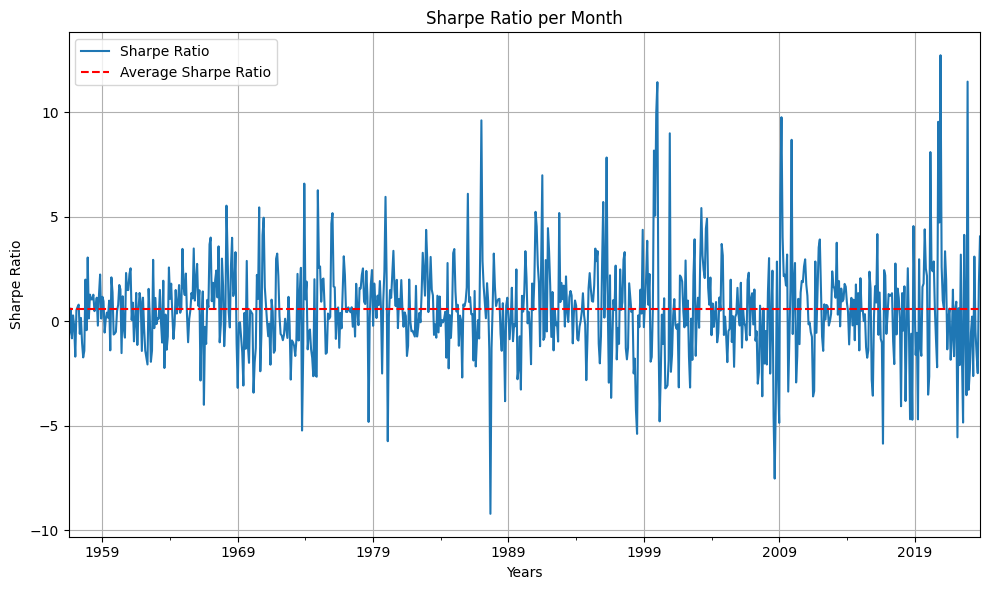

Average Sharpe Ratio: 0.5739548906544224


In [24]:
# Plot the sharpe ratio for each month
ax = plt.subplot()
sharpes = pd.DataFrame(sharpe_ratios, index=dates_with_data, columns=['Sharpe Ratio'])
sharpes.plot(figsize=(10,6), ax=ax)
ax.plot(sharpes.index, [np.mean(sharpes)] * len(sharpes.index), 'r--', label="Average Sharpe Ratio")
ax.set_xlabel("Years")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio per Month")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()
print(f"Average Sharpe Ratio: {np.mean(sharpes)}")

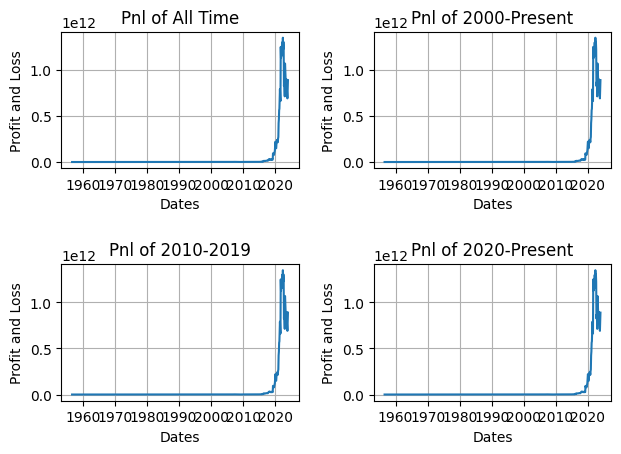

In [22]:
#This plots the Pnl over 4 time periods (all time, 2000-present, 2010-2019, 2020-present)
fig, axs = plt.subplots(2, 2)
# y0, y1 = 1e-12,5e-1

axs[0,0].set_title('Pnl of All Time') 
axs[0,0].plot(dates_with_data, pnl_curves)
axs[0,0].grid()

axs[0,1].set_title('Pnl of 2000-Present') 
axs[0,1].plot(dates_with_data, pnl_curves)
axs[0,1].grid()

axs[1,0].set_title('Pnl of 2010-2019') 
axs[1,0].plot(dates_with_data, pnl_curves)
axs[1,0].grid()

axs[1,1].set_title('Pnl of 2020-Present') 
axs[1,1].plot(dates_with_data, pnl_curves)
axs[1,1].grid()


for ax in axs.flat:
    ax.set(xlabel='Dates', ylabel='Profit and Loss')
fig.tight_layout()
plt.show()